In [22]:
try:
    import anastruct, openturns, numba, joblib
except:
    import os
    if os.sys.platform == 'linux' :
        file_path = 'sensitivityEnv.yml'
        os.system('conda env create -f'+file_path)
        # to have the right modules installed
        print('now activate the environment and restart jupyter with other kernel')
    else :
        print('Do it alone')

In [23]:
import NdGaussianProcessSensitivity_MOD as ngps
import NdGaussianProcessConstructor as ngpc
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 

# on importe aussi les fonctions à étudier
import RandomBeamGenerationClass    as rbgc

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

Populating the interactive namespace from numpy and matplotlib


In [24]:
# process governing the young modulus for each element      (MPa)
process_E = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':5000.,
                                                                'scale':300,
                                                                'nu':13/3},
                                              trend_arguments=['x'],trend_function=210000)
process_E.setName('E_')


# process governing the diameter for each element          (mm)
process_D = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':.3,
                                                                'scale':250,
                                                                'nu':7.4/3},
                                              trend_arguments=['x'],trend_function=10)
process_D.setName('D_')


# random variable for the density of the material (kg/m³)
rho         = 7850.
sigma       = 250
nameD       = 'Rho'
RV_Rho = ngpc.NormalDistribution(mu = rho, sigma = sigma, name = nameD)


# random variable for the position of the force   (mm) 
middle       = 500
sigma_f      = 50
namePos     = 'FP'
RV_Fpos = ngpc.NormalDistribution(mu = middle, sigma = sigma_f, name = namePos)


# random variable for the norm of the force    (N)
muForce       = 100
# we go from sigma = 15 to sigma = 1.5, as the influence is too important
sigma_Fnor    = 1.5
nameNor       = 'FN'
RV_Fnorm = ngpc.NormalDistribution(mu = muForce, sigma = sigma_Fnor, name = nameNor)

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


In [25]:
from importlib import reload
reload(ngps)
outputVariables = {'out1' :
                   {
                         'name'     : 'VonMisesStress',
                         'position' : 0,
                         'shape'    : (102,)  
                    },
                   'out2' :
                   {
                        'name'      : 'maxDeflection',
                        'position'  : 1,
                        'shape'     : (1,)
                   }
                  }
#Pour utiliser notre fonction, un wrapper a été spécialement écrit pour faciliter l'accès aux fonctions mais
#ce choix est entièrement dépendant de la manière dont a été définie la fonction sur laquelle vous travaillez.
functionWrapper = rbgc.sampleAndSoloFunctionWrapper(process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm)


In [ ]:
inputVarList = [process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm]
# We also the need the two functions of the model (one for samples, the other for single evaluations)
# In our case, as our model is defined as a class, we have to first create the model, 
# but it also could just be just two functions taking as an input the fields and RVs
soloFunction   = functionWrapper.randomBeamFunctionSolo
sampleFunction = functionWrapper.randomBeamFunctionSample
##
size           = 2000 ## Number of samples for our sobol indicies experiment (kept low here to make things faster)
##
reload(ngps)
##
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputVarList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

In [ ]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()

In [ ]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

In [ ]:
import NdGaussianProcessSensitivityIndices as ngpsi
reload(ngpsi)
processSensitivityAnalysis.outputDesignList

In [20]:
output = processSensitivityAnalysis.outputDesignList
output1 = output[0]
output2 = output[1]
S, Stot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1,800)
S2, Stot2 = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output2,800)

Populating the interactive namespace from numpy and matplotlib
There are 5 indices to get in (102,) dimensions with 102 elements
There are 5 indices to get in 1 dimensions with 1 elements


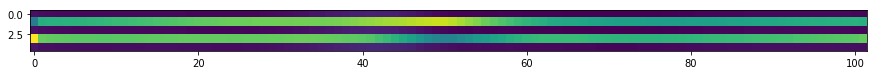

In [21]:
composedDist = processSensitivityAnalysis.wrappedFunction.KLComposedDistribution
plt.imshow(S)

In [17]:
S[...,0:5]

array([[-0.01994839, -0.0308146 , -0.03274779, -0.03435543, -0.03581407],
       [ 0.27219881,  0.43220857,  0.44026895,  0.44233892,  0.44447003],
       [-0.02002383, -0.03088026, -0.03281251, -0.03441967, -0.03587782],
       [ 0.72714773,  0.54497628,  0.53472017,  0.5319345 ,  0.53000425],
       [-0.00787639, -0.02229634, -0.02417193, -0.02554516, -0.02672383]])

In [2]:
sob = list(S2)
Sobol=list()
[Sobol.append(round(x,3)) for x in sob]

NameError: name 'S2' is not defined

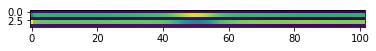

In [36]:
im = plt.imshow(S)

In [37]:
plt.show(im)

In [14]:
print(processSensitivityAnalysis.wrappedFunction.inputVarNames)
print(processSensitivityAnalysis.wrappedFunction.inputVarNamesKL)
print(processSensitivityAnalysis.wrappedFunction._inputVarOrdering)

['E_', 'D_', 'Rho', 'FP', 'FN']
['E_xi_0', 'E_xi_1', 'E_xi_2', 'E_xi_3', 'E_xi_4', 'E_xi_5', 'E_xi_6', 'E_xi_7', 'D_xi_0', 'D_xi_1', 'D_xi_2', 'D_xi_3', 'D_xi_4', 'D_xi_5', 'D_xi_6', 'D_xi_7', 'D_xi_8', 'D_xi_9', 'D_xi_10', 'D_xi_11', 'D_xi_12', 'Rho', 'FP', 'FN']
['var0', 'var1', 'var2', 'var3', 'var4']


In [12]:
import customWraps as cw

In [13]:
@cw.timing
def getLHSExperiment(distribution, size, alwaysShuffle, randomShift):
    return ot.LHSExperiment(distribution, size, alwaysShuffle, randomShift).generate()

In [14]:
exp = getLHSExperiment(composedDist, 2000, True, True)

timed  0.040719986  s for function " getLHSExperiment "


In [15]:
print('That works really fast!')
exp

That works really fast!


class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2000 dimension=24 description=[X0,X1,X2,...,X21,X22,X23] data=[[55.7903,-0.190982,23.284,...,8005.52,484.736,101.649],[55.3335,1.37126,24.2084,...,7653.51,481.986,97.7207],[54.2023,0.871355,23.8598,...,7814.16,407.555,99.9938],...,[54.8515,-0.523946,24.2193,...,8217.19,477.841,99.5037],[54.4046,-0.329352,25.9664,...,7412.34,507.69,98.9423],[54.3466,-0.570135,24.4115,...,7878.01,402.964,99.9011]]

In [55]:
import NdGaussianProcessExperimentGeneration as ngpeg
reload(ngpeg)

<module 'NdGaussianProcessExperimentGeneration' from '/home/motherloadubu/Documents/project_PHIMECA/stochastic_process_analysis/NdGaussianProcessExperimentGeneration.py'>

In [56]:
test0 = ngpeg.NdGaussianProcessExperiment(processSensitivityAnalysis.sampleSize,
                                         processSensitivityAnalysis.wrappedFunction)

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS


In [57]:
test0.generate()

array([[ 5.50346146e+01,  9.81992100e-02,  2.47360736e+01, ...,
         7.45248899e+03,  6.01817823e+02,  1.01293963e+02],
       [ 5.37555756e+01,  1.29455188e-01,  2.28109014e+01, ...,
         7.95669043e+03,  4.37887664e+02,  9.96609256e+01],
       [ 5.53507742e+01, -1.25225486e+00,  2.43850209e+01, ...,
         7.96235937e+03,  4.37713257e+02,  1.00149113e+02],
       ...,
       [ 5.60095120e+01,  7.35625214e-01,  2.33273992e+01, ...,
         8.07962019e+03,  5.26993032e+02,  1.00278874e+02],
       [ 5.65213904e+01,  3.75193848e-01,  2.45633504e+01, ...,
         7.82180335e+03,  5.20321230e+02,  9.79694576e+01],
       [ 5.47746640e+01,  1.08818884e+00,  2.43071075e+01, ...,
         7.95333093e+03,  5.59042152e+02,  9.89984624e+01]])

In [49]:
test0.getDataFieldAndRV()

In [50]:
test0.getExperiment()

In [22]:
test = ngpeg.NdGaussianProcessExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS


In [23]:
test.setSampleSize(100)

In [24]:
test.setOTPyFunctionWrapper(processSensitivityAnalysis.wrappedFunction)

In [25]:
test.setGenType(1)
test.generateSample()

In [26]:
test.setGenType(2)
test.generateSample()

In [27]:
test.setGenType(3)
test.generateSample(sequence='Halton')

In [28]:
test.setGenType(4)
arr=test.generateSample()

undefined parameter 'SpaceFilling', setting to default 'SpaceFillingC2'
undefined parameter 'TemperatureProfile', setting default GeometricProfile


In [29]:
print(test.inputVarNames)
print(test.inputVarNamesKL)
test.getDataFieldAndRV()

['E_', 'D_', 'Rho', 'FP', 'FN']
['E_xi_0', 'E_xi_1', 'E_xi_2', 'E_xi_3', 'E_xi_4', 'E_xi_5', 'E_xi_6', 'E_xi_7', 'D_xi_0', 'D_xi_1', 'D_xi_2', 'D_xi_3', 'D_xi_4', 'D_xi_5', 'D_xi_6', 'D_xi_7', 'D_xi_8', 'D_xi_9', 'D_xi_10', 'D_xi_11', 'D_xi_12', 'Rho', 'FP', 'FN']


In [30]:
test.dataMixSamples

[8, 13, 1, 1, 1]

In [31]:
test.sample_A.shape

(100, 24)

In [32]:
test.getExperiment()

In [33]:
test.experimentSample.shape

(700, 24)

In [34]:
np.unique(np.argwhere(test.experimentSample[100:200,...]==test.sample_B)[...,1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [35]:
np.unique(np.argwhere(test.experimentSample[200:300,...]==test.sample_B)[...,1])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
np.unique(np.argwhere(test.experimentSample[300:400,...]==test.sample_B)[...,1])

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [37]:
np.unique(np.argwhere(test.experimentSample[400:500,...]==test.sample_B)[...,1])

array([21])

In [38]:
np.unique(np.argwhere(test.experimentSample[500:600,...]==test.sample_B)[...,1])

array([22])

In [39]:
np.unique(np.argwhere(test.experimentSample[600:700,...]==test.sample_B)[...,1])

array([23])

Everything works alright, we get our samples as expected.